# Power Distribution Plot

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk, load_dataset, concatenate_datasets
import librosa
import os

# Define dataset paths
datasets = {
    # "dataset-balanced-arrow": "eval-datasets/dataset-balanced-arrow",
    "wavefake": "eval-datasets/wavefake",
    "fake-or-real":"eval-datasets/fake-or-real",
    "LibreSpeech":"eval-datasets/LibriSpeech/all_wav_files_og",
    "common-voices-mozilla":"eval-datasets/common-voices-mozilla/cv-valid-train/cv-valid-train-wav-clean",
    "LibriSeVoc": "eval-datasets/LibriSeVoc",
    "release_in_the_wild": "eval-datasets/release_in_the_wild",
    "SONAR_dataset": "eval-datasets/SONAR_dataset",
    "ASVSpoof2019": "eval-datasets/ASVSpoof2019"
}

def load_dataset_helper(dataset_path):
    """Load dataset from path, handling both arrow datasets and audio folders"""
    try:
        # First try loading as an arrow dataset
        if os.path.exists(os.path.join(dataset_path, "dataset_dict.json")):
            return load_from_disk(dataset_path)
        # If not an arrow dataset, load as an audio folder
        return load_dataset("audiofolder", data_dir=dataset_path, num_proc=os.cpu_count() - 1, drop_labels=False)
    except Exception as e:
        print(f"Error loading dataset from {dataset_path}: {str(e)}")
        raise

def compute_power(audio_array, sampling_rate):
    """Calculate power of an audio signal (mean of squared values)"""
    return np.mean(audio_array**2)

def is_audio_valid(example):
    """
    Checks if the audio example has a valid, non-empty array.
    Handles potential decoding errors.
    """
    audio_array = example["input_values"]["array"]
    return audio_array is not None and len(audio_array) > 0

In [25]:
def load_and_prepare_dataset(dataset_path):
    """Load and prepare the dataset for analysis with error handling"""
    try:
        print(f"Loading dataset from {dataset_path}...")
        dataset = load_dataset_helper(dataset_path)
        
        if not dataset:
            raise ValueError("Empty dataset returned from load_dataset_helper")
            
        print(f"Found splits: {list(dataset.keys())}")
        combined = concatenate_datasets([dataset[split] for split in dataset.keys()])
        combined = combined.rename_column("audio", "input_values")
        print(f"Successfully prepared dataset with {len(combined)} samples")
        return combined
        
    except Exception as e:
        print(f"❌ Error in load_and_prepare_dataset: {str(e)}")
        print(f"Dataset path: {dataset_path}")
        if 'dataset' in locals():
            print(f"Available splits: {list(dataset.keys()) if hasattr(dataset, 'keys') else 'N/A'}")
        raise

In [26]:
def filter_dataset(dataset):
    """Filter out invalid audio examples with error handling"""
    try:
        if not dataset:
            raise ValueError("Empty dataset provided to filter_dataset")
            
        print(f"\nFiltering dataset (current size: {len(dataset)})...")
        filtered = dataset.filter(is_audio_valid)
        print(f"Filtered dataset size: {len(filtered)} " + 
              f"({len(dataset) - len(filtered)} samples removed)")
        return filtered
        
    except Exception as e:
        print(f"❌ Error in filter_dataset: {str(e)}")
        if 'dataset' in locals():
            print(f"Dataset type: {type(dataset)}")
            print(f"Sample keys: {list(dataset[0].keys()) if len(dataset) > 0 else 'No samples'}")
        raise

In [27]:
def sample_dataset(dataset, sample_size=3000):
    """Sample the dataset if it's too large, with error handling"""
    try:
        if not dataset:
            raise ValueError("Empty dataset provided to sample_dataset")
            
        if len(dataset) > sample_size:
            print(f"Sampling {sample_size} from {len(dataset)} examples...")
            sampled = dataset.select(np.random.choice(len(dataset), sample_size, replace=False))
            return sampled
        return dataset
        
    except Exception as e:
        print(f"❌ Error in sample_dataset: {str(e)}")
        if 'dataset' in locals():
            print(f"Dataset size: {len(dataset) if hasattr(dataset, '__len__') else 'N/A'}")
        raise

In [28]:
def compute_power_values(dataset):
    """Compute power values for all audio samples with error handling"""
    power_values = []
    error_count = 0
    
    if not dataset:
        raise ValueError("Empty dataset provided to compute_power_values")
        
    print(f"\nComputing power values for {len(dataset)} samples...")
    
    for i, example in enumerate(dataset, 1):
        try:
            if not isinstance(example, dict) or 'input_values' not in example:
                raise ValueError("Invalid example format - missing 'input_values'")
                
            audio_data = example['input_values']
            if not isinstance(audio_data, dict) or 'array' not in audio_data or 'sampling_rate' not in audio_data:
                raise ValueError("Invalid audio data format - expected dict with 'array' and 'sampling_rate'")
                
            audio_array = audio_data['array']
            sampling_rate = audio_data['sampling_rate']
            
            if not isinstance(audio_array, (np.ndarray, list)) or not isinstance(sampling_rate, (int, float)):
                raise ValueError("Invalid audio array or sampling rate type")
                
            power = compute_power(audio_array, sampling_rate)
            power_db = 10 * np.log10(power) if power > 0 else -100
            power_values.append(power_db)
            
            if i % 100 == 0 or i == len(dataset):
                print(f"Processed {i}/{len(dataset)} samples...", end='\r')
                
        except Exception as e:
            error_count += 1
            print(f"\n⚠️ Error processing sample {i}: {str(e)}")
            if error_count <= 3:  # Print full traceback for first few errors
                import traceback
                traceback.print_exc()
            elif error_count == 4:
                print("Additional errors will be suppressed...")
            continue
    
    print(f"\n✅ Successfully processed {len(power_values)}/{len(dataset)} samples")
    if error_count > 0:
        print(f"⚠️  Encountered {error_count} errors during processing")
    
    return power_values

In [29]:
# Update the main analysis function to include error handling
def analyze_dataset_power(dataset_path, sample_size=3000):
    """Analyze power distribution of a dataset with comprehensive error handling"""
    try:
        print(f"\n{'='*50}")
        print(f"Starting analysis for: {dataset_path}")
        print(f"{'='*50}")
        
        # Step 1: Load and prepare dataset
        dataset = load_and_prepare_dataset(dataset_path)
        
        # Step 2: Filter dataset
        filtered = filter_dataset(dataset)
        
        # Step 3: Sample dataset
        sampled = sample_dataset(filtered, sample_size)
        
        # Step 4: Compute power values
        power_values = compute_power_values(sampled)
        
        if not power_values:
            print("⚠️  No valid power values were computed")
            return None
            
        return power_values
        
    except Exception as e:
        print(f"\n❌❌❌ CRITICAL ERROR in analyze_dataset_power ❌❌❌")
        print(f"Error processing {dataset_path}:")
        print(f"Type: {type(e).__name__}")
        print(f"Message: {str(e)}")
        print("\nStack trace:")
        import traceback
        traceback.print_exc()
        return None

In [30]:
# Block 6: Plotting function
def plot_power_distributions(power_distributions):
    """Plot power distributions for all datasets"""
    plt.figure(figsize=(12, 8))
    for name, power_db in power_distributions.items():
        if power_db:
            plt.hist(power_db, bins=50, alpha=0.5, label=name, density=True)
    plt.xlabel("Power (dB)")
    plt.ylabel("Density")
    plt.title("Power Distribution Comparison Across Datasets")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("power_distribution_comparison.png")
    plt.show()

In [31]:
def plot_individual_distributions(power_distributions, bins=50):
    """Create individual distribution plots for each dataset"""
    n = len(power_distributions)
    if n == 0:
        print("No data to plot")
        return
    
    # Create a grid of subplots
    cols = min(2, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    
    # Flatten axes if we have a 2D array
    if rows > 1:
        axes = axes.flatten()
    
    for ax, (name, power_db) in zip(axes, power_distributions.items()):
        if not power_db:
            continue
            
        # Plot histogram
        ax.hist(power_db, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Add mean and median lines
        mean_val = np.mean(power_db)
        median_val = np.median(power_db)
        ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.1f} dB')
        ax.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.1f} dB')
        
        # Add stats text
        stats = (f'Samples: {len(power_db)}\n'
                 f'Min: {np.min(power_db):.1f} dB\n'
                 f'Max: {np.max(power_db):.1f} dB\n'
                 f'Std: {np.std(power_db):.1f} dB')
        
        ax.text(0.95, 0.95, stats,
                transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'Power Distribution: {name}')
        ax.set_xlabel('Power (dB)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)
    
    # Hide any unused subplots
    for i in range(len(power_distributions), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig("individual_power_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_combined_distribution(power_distributions, bins=50):
    """Create a single plot with all distributions overlaid"""
    plt.figure(figsize=(12, 8))
    
    # Create a colormap for different datasets
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(power_distributions)))
    
    for (name, power_db), color in zip(power_distributions.items(), colors):
        if power_db:
            plt.hist(power_db, bins=bins, alpha=0.5, 
                    label=f"{name} (n={len(power_db)})",
                    color=color)
    
    plt.title("Power Distribution Comparison Across Datasets")
    plt.xlabel("Power (dB)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("combined_power_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_statistics(power_distributions):
    """Print statistical summary of power distributions"""
    print("\nStatistical Summary:")
    for name, power_db in power_distributions.items():
        if power_db:
            print(f"\n{name}:")
            print(f"  Mean: {np.mean(power_db):.2f} dB")
            print(f"  Std: {np.std(power_db):.2f} dB")
            print(f"  Min: {np.min(power_db):.2f} dB")
            print(f"  Max: {np.max(power_db):.2f} dB")
            print(f"  Samples: {len(power_db)}")


In [32]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
def extract_audio_features(audio_data, sr):
    """Extract multiple audio features for t-SNE analysis"""
    features = {}
    
    # Basic statistics of the waveform
    features['rms'] = np.sqrt(np.mean(np.square(audio_data)))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio_data))
    
    # Spectral features
    stft = np.abs(librosa.stft(audio_data))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(S=stft))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=stft))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=stft))
    
    # MFCCs (first 5 coefficients)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=5)
    for i, coef in enumerate(mfccs):
        features[f'mfcc_{i+1}_mean'] = np.mean(coef)
        features[f'mfcc_{i+1}_std'] = np.std(coef)
    
    return features

def compute_tsne_embeddings(power_distributions, sample_size=1000, random_state=42):
    """
    Compute t-SNE embeddings using multiple audio features
    """
    all_features = []
    all_labels = []
    
    for name, power_db in power_distributions.items():
        if not power_db:
            continue
            
        print(f"Extracting features for {name}...")
        dataset = load_and_prepare_dataset(datasets[name])  # Assuming you have a datasets dict
        
        # Sample if dataset is large
        if len(dataset) > sample_size:
            dataset = dataset.select(np.random.choice(len(dataset), sample_size, replace=False))
        
        for example in dataset:
            try:
                audio_data = example['input_values']
                features = extract_audio_features(
                    audio_data['array'], 
                    audio_data['sampling_rate']
                )
                all_features.append(list(features.values()))
                all_labels.append(name)
            except Exception as e:
                print(f"Error processing example: {e}")
                continue
    
    if not all_features:
        print("No valid features extracted")
        return None
    
    # Convert to numpy arrays
    X = np.array(all_features)
    y = np.array(all_labels)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Compute t-SNE
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, 
                perplexity=min(30, len(X_scaled) - 1),
                random_state=random_state,
                n_jobs=-1)
    
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Create DataFrame with results
    tsne_df = pd.DataFrame({
        'tsne_1': X_tsne[:, 0],
        'tsne_2': X_tsne[:, 1],
        'dataset': y
    })
    
    return tsne_df

def plot_tsne(tsne_df, figsize=(12, 8)):
    """Plot t-SNE visualization with improved styling"""
    if tsne_df is None or len(tsne_df) == 0:
        print("No data to plot")
        return
    
    plt.figure(figsize=figsize)
    
    # Create a color palette with distinct colors
    palette = sns.color_palette("husl", n_colors=len(tsne_df['dataset'].unique()))
    
    # Create scatter plot
    scatter = sns.scatterplot(
        x='tsne_1', 
        y='tsne_2',
        hue='dataset',
        data=tsne_df,
        palette=palette,
        alpha=0.7,
        s=50,
        edgecolor='none'
    )
    
    # Improve plot styling
    plt.title('t-SNE Visualization of Audio Features', fontsize=14, pad=20)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    
    # Adjust legend
    plt.legend(
        title='Dataset',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        frameon=True,
        framealpha=0.9
    )
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.2)
    
    # Remove top and right spines
    sns.despine()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save high-quality figure
    plt.savefig('tsne_audio_features.png', dpi=300, bbox_inches='tight')
    plt.show()

Analyzing wavefake...

Starting analysis for: eval-datasets/wavefake
Loading dataset from eval-datasets/wavefake...


Resolving data files:   0%|          | 0/117983 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 117983 samples

Filtering dataset (current size: 117983)...
Filtered dataset size: 117983 (0 samples removed)
Sampling 3000 from 117983 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing fake-or-real...

Starting analysis for: eval-datasets/fake-or-real
Loading dataset from eval-datasets/fake-or-real...


Resolving data files:   0%|          | 0/53868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10798 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4634 [00:00<?, ?it/s]

Found splits: ['train', 'validation', 'test']
Successfully prepared dataset with 69300 samples

Filtering dataset (current size: 69300)...
Filtered dataset size: 69298 (2 samples removed)
Sampling 3000 from 69298 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing LibreSpeech...

Starting analysis for: eval-datasets/LibriSpeech/all_wav_files_og
Loading dataset from eval-datasets/LibriSpeech/all_wav_files_og...


Resolving data files:   0%|          | 0/104014 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 104014 samples

Filtering dataset (current size: 104014)...
Filtered dataset size: 104014 (0 samples removed)
Sampling 3000 from 104014 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing common-voices-mozilla...

Starting analysis for: eval-datasets/common-voices-mozilla/cv-valid-train/cv-valid-train-wav-clean
Loading dataset from eval-datasets/common-voices-mozilla/cv-valid-train/cv-valid-train-wav-clean...


Resolving data files:   0%|          | 0/195771 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 195771 samples

Filtering dataset (current size: 195771)...
Filtered dataset size: 195771 (0 samples removed)
Sampling 3000 from 195771 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing LibriSeVoc...

Starting analysis for: eval-datasets/LibriSeVoc
Loading dataset from eval-datasets/LibriSeVoc...


Resolving data files:   0%|          | 0/92407 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 92407 samples

Filtering dataset (current size: 92407)...
Filtered dataset size: 92407 (0 samples removed)
Sampling 3000 from 92407 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing release_in_the_wild...

Starting analysis for: eval-datasets/release_in_the_wild
Loading dataset from eval-datasets/release_in_the_wild...


Resolving data files:   0%|          | 0/31781 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 31779 samples

Filtering dataset (current size: 31779)...
Filtered dataset size: 31779 (0 samples removed)
Sampling 3000 from 31779 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing SONAR_dataset...

Starting analysis for: eval-datasets/SONAR_dataset
Loading dataset from eval-datasets/SONAR_dataset...


Resolving data files:   0%|          | 0/3948 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 3948 samples

Filtering dataset (current size: 3948)...
Filtered dataset size: 3948 (0 samples removed)
Sampling 3000 from 3948 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples
Analyzing ASVSpoof2019...

Starting analysis for: eval-datasets/ASVSpoof2019
Loading dataset from eval-datasets/ASVSpoof2019...


Resolving data files:   0%|          | 0/96081 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 96081 samples

Filtering dataset (current size: 96081)...
Filtered dataset size: 96081 (0 samples removed)
Sampling 3000 from 96081 examples...

Computing power values for 3000 samples...
Processed 3000/3000 samples...
✅ Successfully processed 3000/3000 samples


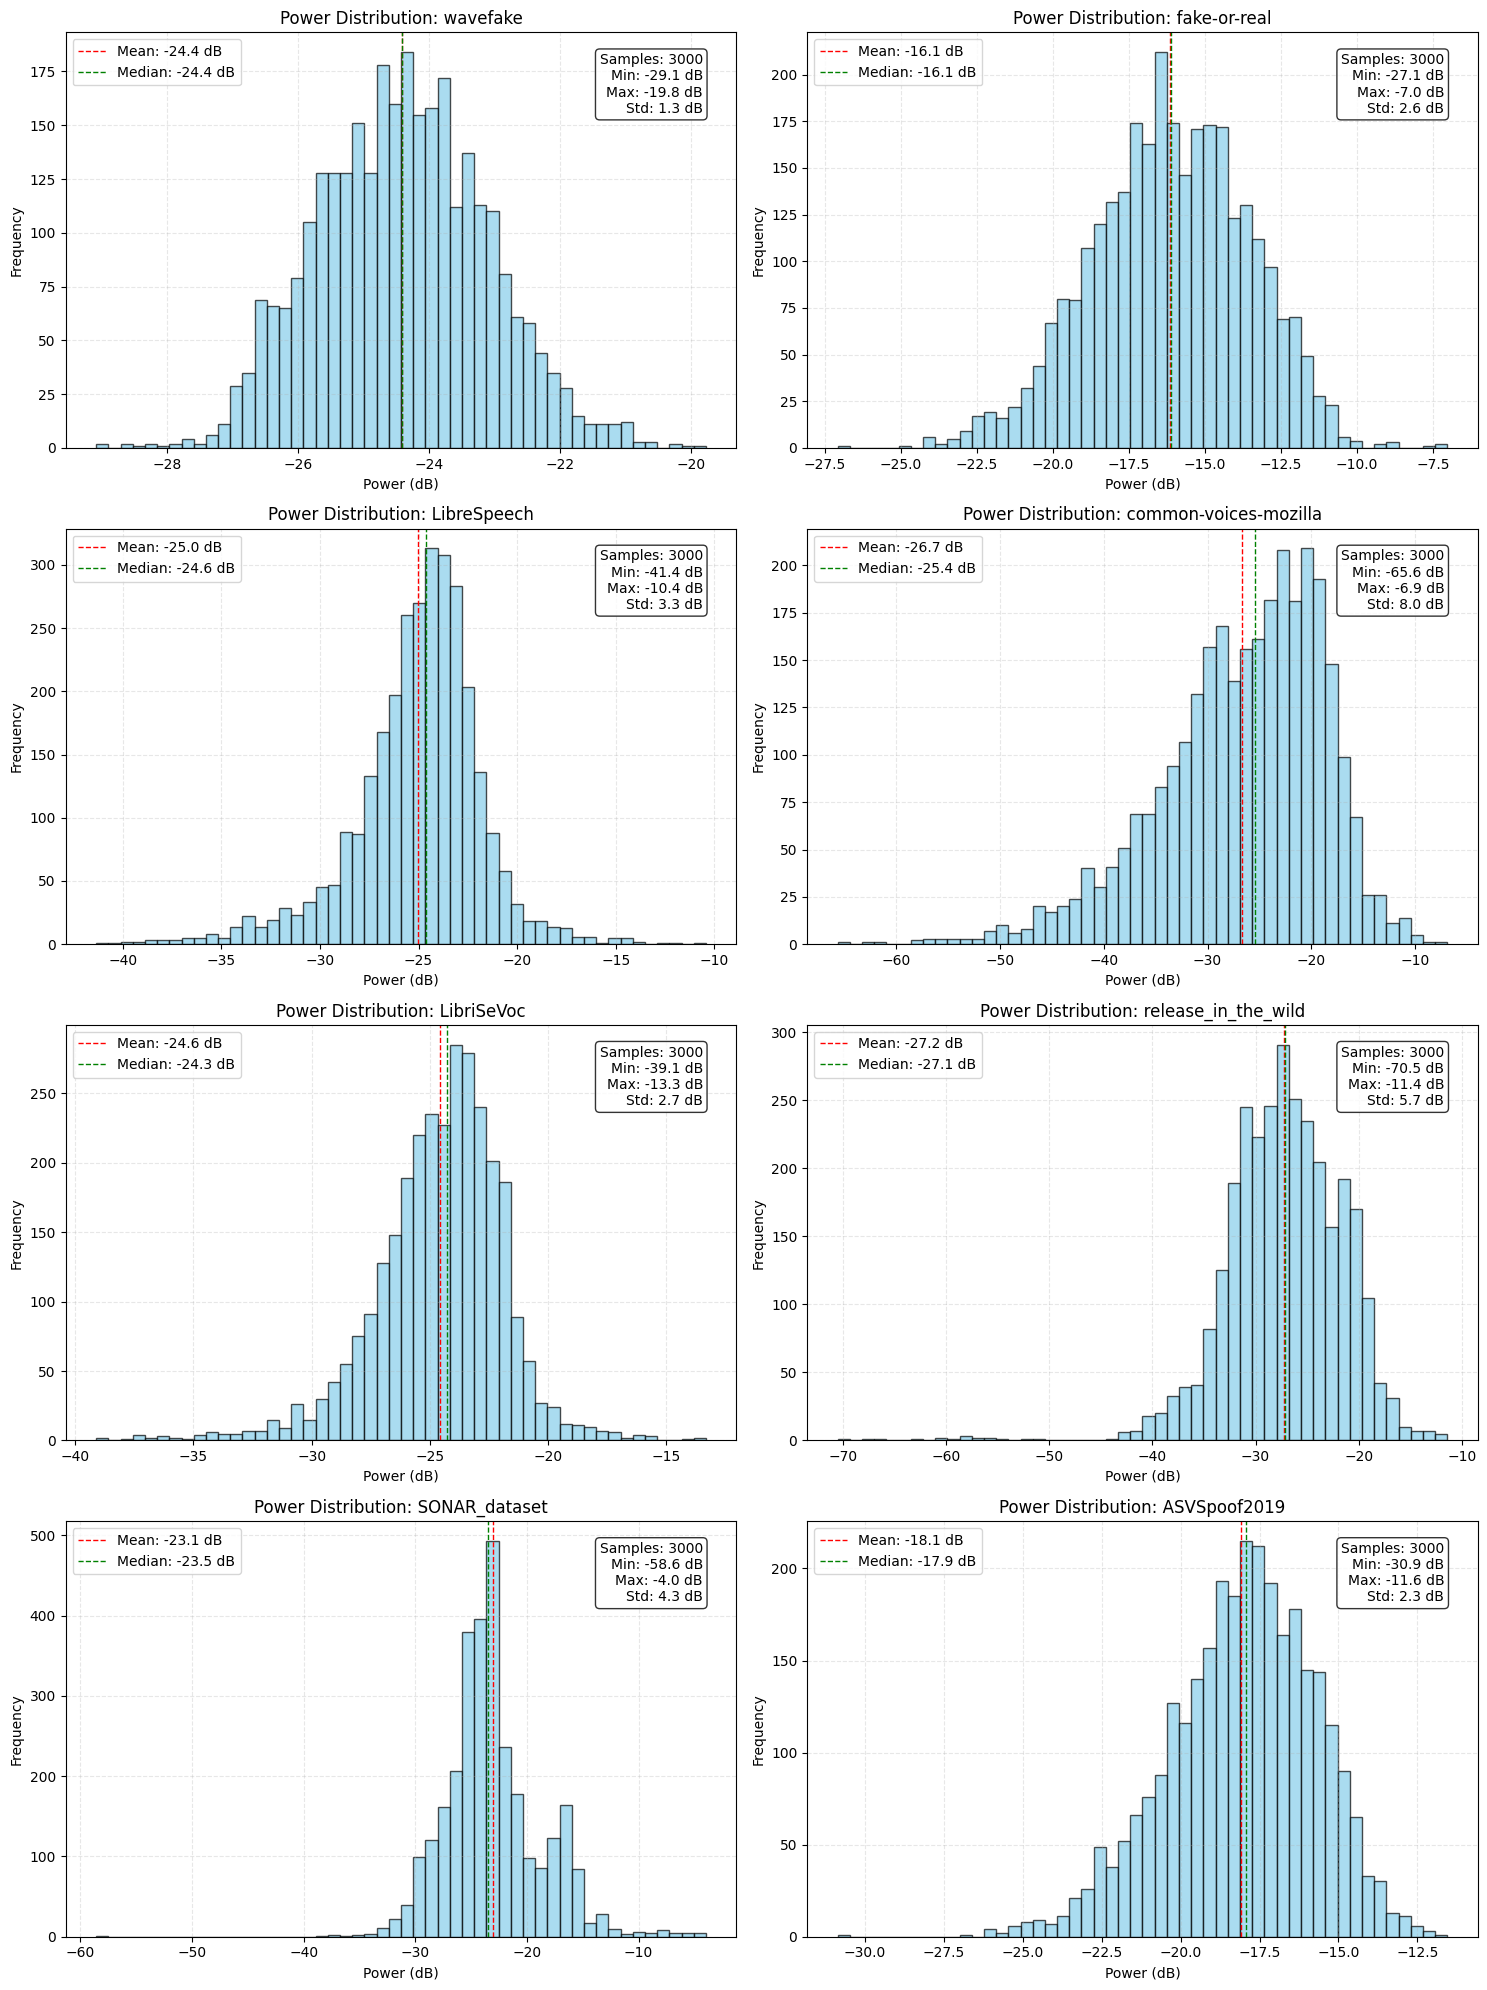

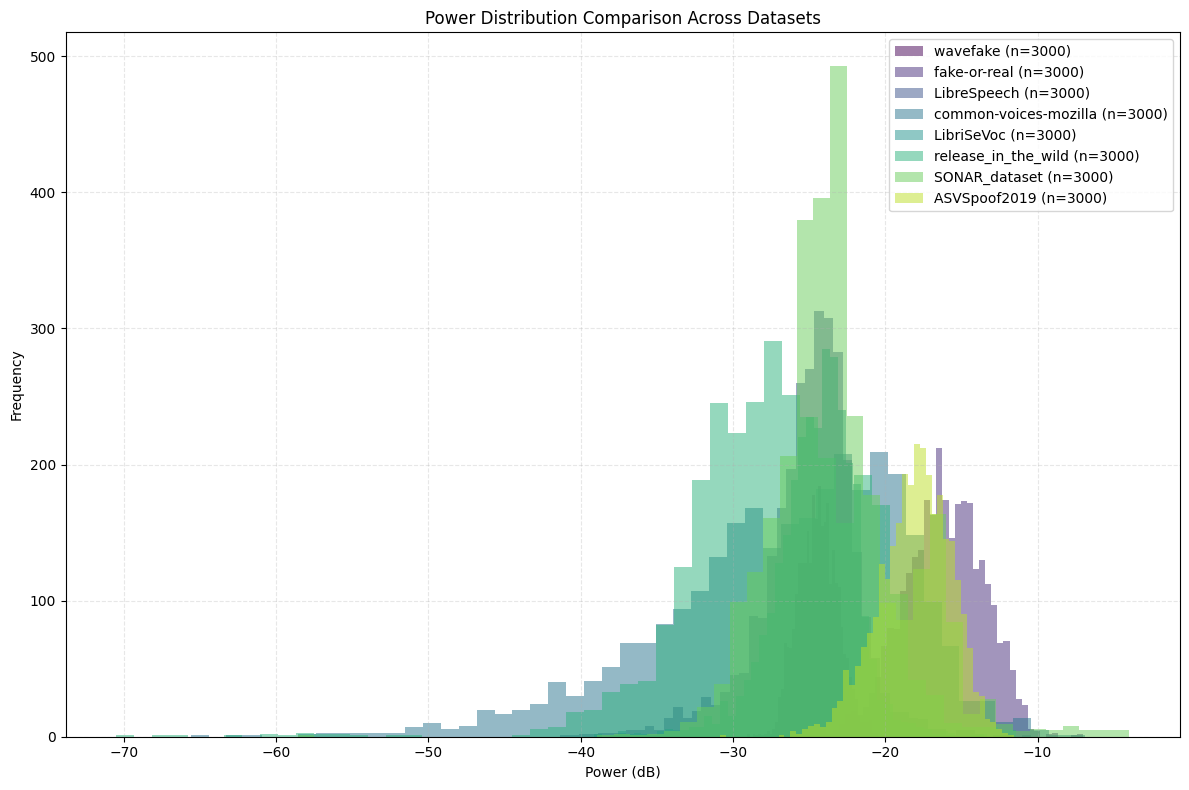


Statistical Summary:

wavefake:
  Mean: -24.41 dB
  Std: 1.30 dB
  Min: -29.09 dB
  Max: -19.77 dB
  Samples: 3000

fake-or-real:
  Mean: -16.14 dB
  Std: 2.59 dB
  Min: -27.07 dB
  Max: -7.03 dB
  Samples: 3000

LibreSpeech:
  Mean: -25.03 dB
  Std: 3.26 dB
  Min: -41.35 dB
  Max: -10.42 dB
  Samples: 3000

common-voices-mozilla:
  Mean: -26.70 dB
  Std: 7.95 dB
  Min: -65.62 dB
  Max: -6.91 dB
  Samples: 3000

LibriSeVoc:
  Mean: -24.59 dB
  Std: 2.74 dB
  Min: -39.11 dB
  Max: -13.33 dB
  Samples: 3000

release_in_the_wild:
  Mean: -27.22 dB
  Std: 5.65 dB
  Min: -70.50 dB
  Max: -11.42 dB
  Samples: 3000

SONAR_dataset:
  Mean: -23.06 dB
  Std: 4.34 dB
  Min: -58.59 dB
  Max: -3.97 dB
  Samples: 3000

ASVSpoof2019:
  Mean: -18.08 dB
  Std: 2.35 dB
  Min: -30.87 dB
  Max: -11.55 dB
  Samples: 3000

Performing t-SNE analysis...
Extracting features for wavefake...
Loading dataset from eval-datasets/wavefake...


Resolving data files:   0%|          | 0/117983 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 117983 samples
Extracting features for fake-or-real...
Loading dataset from eval-datasets/fake-or-real...


Resolving data files:   0%|          | 0/53868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10798 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4634 [00:00<?, ?it/s]

Found splits: ['train', 'validation', 'test']
Successfully prepared dataset with 69300 samples
Extracting features for LibreSpeech...
Loading dataset from eval-datasets/LibriSpeech/all_wav_files_og...


Resolving data files:   0%|          | 0/104014 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 104014 samples
Extracting features for common-voices-mozilla...
Loading dataset from eval-datasets/common-voices-mozilla/cv-valid-train/cv-valid-train-wav-clean...


Resolving data files:   0%|          | 0/195771 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 195771 samples
Extracting features for LibriSeVoc...
Loading dataset from eval-datasets/LibriSeVoc...


Resolving data files:   0%|          | 0/92407 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 92407 samples
Extracting features for release_in_the_wild...
Loading dataset from eval-datasets/release_in_the_wild...


Resolving data files:   0%|          | 0/31781 [00:00<?, ?it/s]

Found splits: ['train']
Successfully prepared dataset with 31779 samples
Extracting features for SONAR_dataset...
Loading dataset from eval-datasets/SONAR_dataset...


Resolving data files:   0%|          | 0/3948 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 3948 samples
Extracting features for ASVSpoof2019...
Loading dataset from eval-datasets/ASVSpoof2019...


Resolving data files:   0%|          | 0/96081 [00:00<?, ?it/s]

Found splits: ['test']
Successfully prepared dataset with 96081 samples
Computing t-SNE...


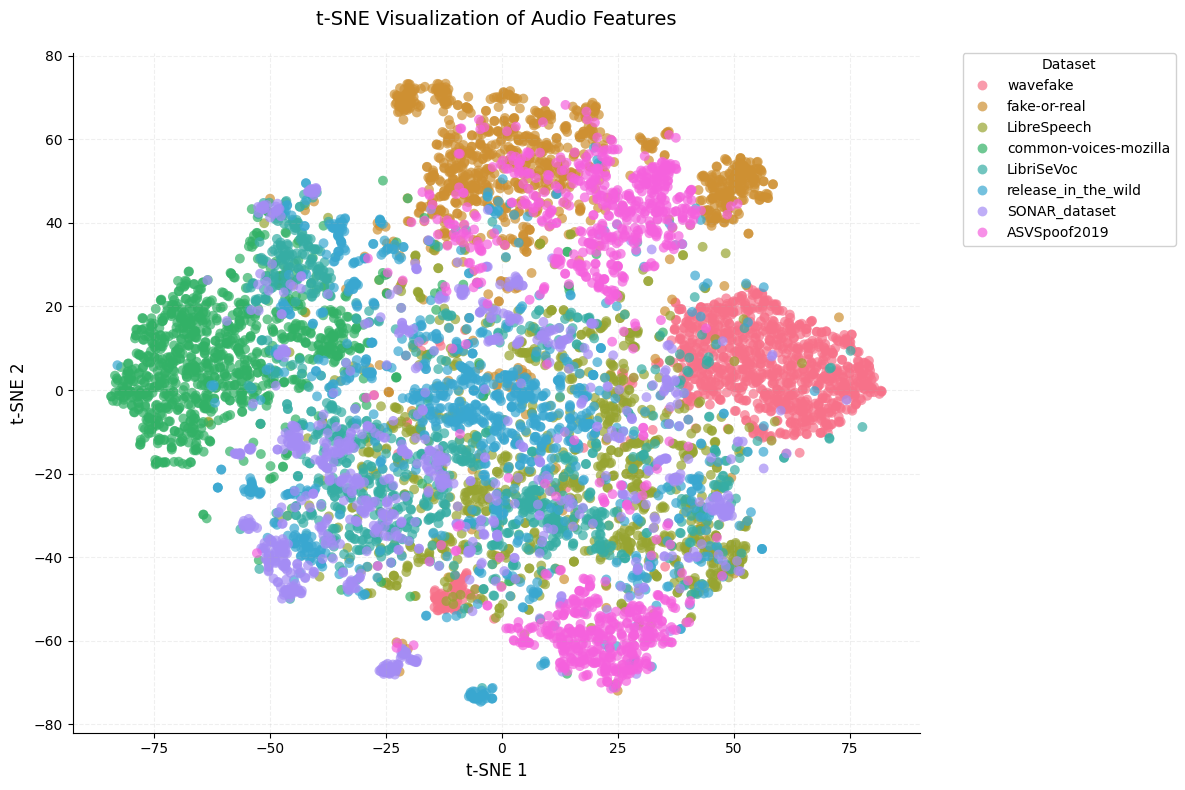

In [33]:
# Block 8: Main execution
def main():
    # Analyze all datasets
    power_distributions = {}
    for name, path in datasets.items():
        print(f"Analyzing {name}...")
        power_distributions[name] = analyze_dataset_power(path)
    
    # Remove any None values from failed analyses
    power_distributions = {k: v for k, v in power_distributions.items() if v is not None}
    
    # Create plots
    if power_distributions:
        plot_individual_distributions(power_distributions)
        plot_combined_distribution(power_distributions)
        print_statistics(power_distributions)
        
        print("\nPerforming t-SNE analysis...")
        tsne_df = compute_tsne_embeddings(power_distributions)
        if tsne_df is not None:
            plot_tsne(tsne_df)
        else:
            print("Skipping t-SNE due to insufficient data")
    else:
        print("No valid data to process")

main()

Training metrics plot saved to: c:\Users\crumbz\Downloads\thesis-testing\eval-checkpoints\ast_classifier\7th-iteration\training_metrics.png


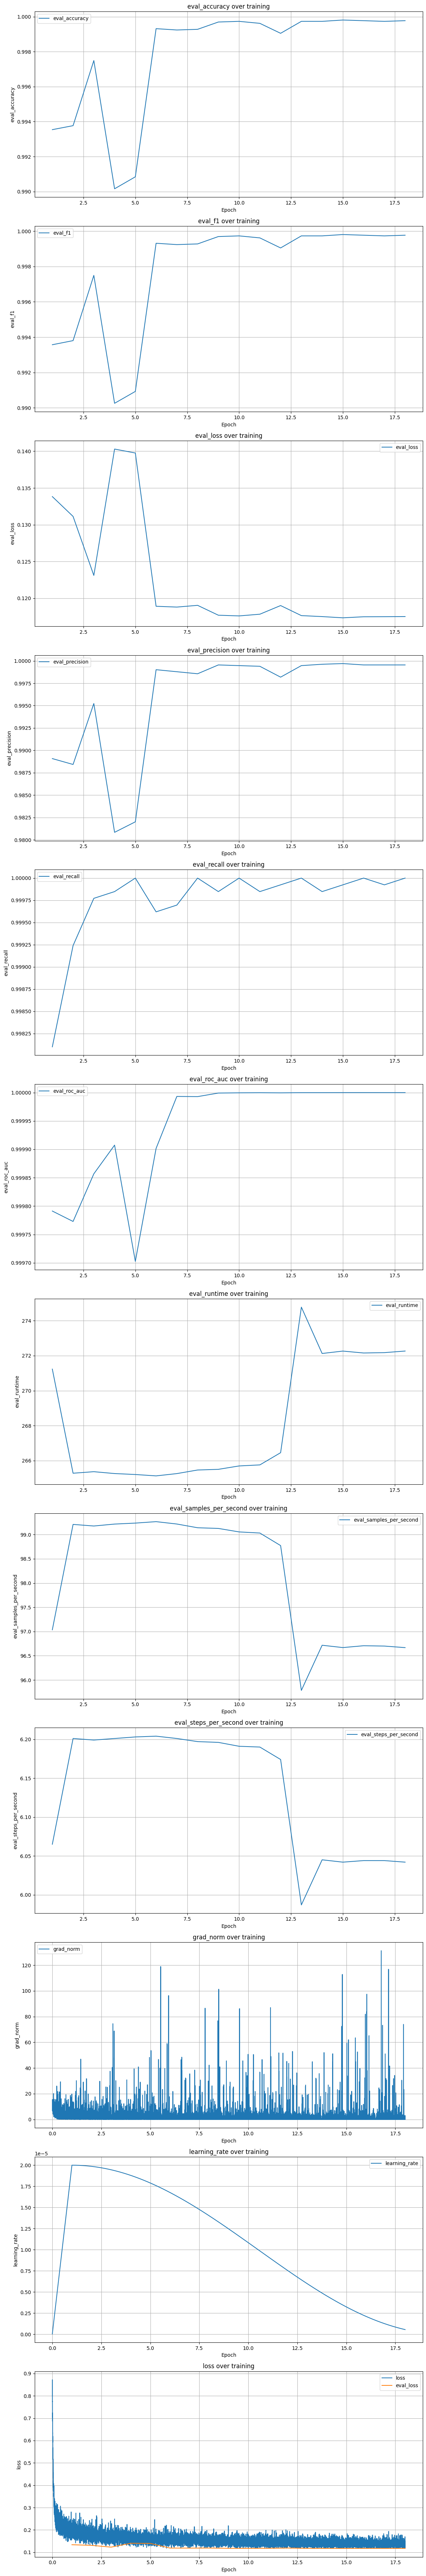

In [34]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

def load_training_logs(log_path):
    with open(log_path, 'r') as f:
        data = json.load(f)
    return data['log_history']

def process_logs(logs):
    metrics = defaultdict(list)
    
    for entry in logs:
        epoch = entry.get('epoch')
        if epoch is None:
            continue
            
        for key, value in entry.items():
            if key != 'epoch' and key != 'step':
                metrics[key].append((epoch, value))
    
    return metrics

def plot_metrics(metrics, save_path=None):
    # If no metrics with slashes, use all metrics
    metric_types = set(key.split('/')[-1] for key in metrics.keys())
    
    # Create subplots for each metric type
    fig, axs = plt.subplots(len(metric_types), 1, figsize=(12, 6 * len(metric_types)))
    
    # If only one metric type, convert axs to list for consistent handling
    if len(metric_types) == 1:
        axs = [axs]
    
    for i, metric_type in enumerate(sorted(metric_types)):
        # Get all metrics of this type
        metric_data = {k: v for k, v in metrics.items() if k.endswith(metric_type)}
        
        for metric_name, values in metric_data.items():
            epochs, scores = zip(*values)
            axs[i].plot(epochs, scores, label=metric_name)
        
        axs[i].set_title(f'{metric_type} over training')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric_type)
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

def main():
    # Path to the trainer_state.json
    log_path = r'c:\Users\crumbz\Downloads\thesis-testing\eval-checkpoints\ast_classifier\7th-iteration\trainer_state.json'
    output_path = r'c:\Users\crumbz\Downloads\thesis-testing\eval-checkpoints\ast_classifier\7th-iteration\training_metrics.png'
    
    # Load and process logs
    logs = load_training_logs(log_path)
    metrics = process_logs(logs)
    
    # Plot metrics
    plot_metrics(metrics, output_path)
    print(f"Training metrics plot saved to: {output_path}")

if __name__ == "__main__":
    main()
